# Import necessary libraries

In [1]:
import pandas as pd
import re
import os
import nltk
import string
import pandas as pd
nltk.download('stopwords')
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
from itertools import chain
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
import email
import multiprocessing
import seaborn as sns
import email
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vamsi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the Data

In [2]:
directory = r'C:\Users\vamsi\Downloads\Text analytics\Text\Categories'
file_name =[]
emails =[]
category = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.txt'):
            file_name.append(file[:-4])
            for f in root:
                file_open = open(os.path.join(root, file),'r')
                line = file_open.read()
                emails.append(line)
        if file.endswith('.cats'):
            for f in root:
                category.append(root[-1])

# Creating DataFrame

In [3]:
df=pd.DataFrame({'message':emails,'category':category})

**Drooping Duplicated values from the Data**

In [4]:
df=df.drop_duplicates(keep='first')
df.head()

,message,category
0,Message-ID: <197504.1075840201539.JavaMail.eva...,1
57,Message-ID: <11991339.1075842536086.JavaMail.e...,1
114,Message-ID: <7106753.1075842536132.JavaMail.ev...,1
171,Message-ID: <21267718.1075863331587.JavaMail.e...,1
228,Message-ID: <20866019.1075863331634.JavaMail.e...,1


**Reseting the index**

In [5]:
df=df.reset_index(drop=True)
df.head()

,message,category
0,Message-ID: <197504.1075840201539.JavaMail.eva...,1
1,Message-ID: <11991339.1075842536086.JavaMail.e...,1
2,Message-ID: <7106753.1075842536132.JavaMail.ev...,1
3,Message-ID: <21267718.1075863331587.JavaMail.e...,1
4,Message-ID: <20866019.1075863331634.JavaMail.e...,1


In [6]:
#getting first 5 rows 
df.head()

,message,category
0,Message-ID: <197504.1075840201539.JavaMail.eva...,1
1,Message-ID: <11991339.1075842536086.JavaMail.e...,1
2,Message-ID: <7106753.1075842536132.JavaMail.ev...,1
3,Message-ID: <21267718.1075863331587.JavaMail.e...,1
4,Message-ID: <20866019.1075863331634.JavaMail.e...,1


In [7]:
print(df.loc[1]['message'])

Message-ID: <11991339.1075842536086.JavaMail.evans@thyme>
Date: Mon, 5 Mar 2001 08:23:00 -0800 (PST)
From: drew.fossum@enron.com
To: darrell.schoolcraft@enron.com
Subject: TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTORNEY CLIENT PRIVILEGE
Cc: danny.mccarty@enron.com, steven.harris@enron.com, kevin.hyatt@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: danny.mccarty@enron.com, steven.harris@enron.com, kevin.hyatt@enron.com
X-From: Drew Fossum
X-To: Darrell Schoolcraft
X-cc: Danny McCarty, Steven Harris, Kevin Hyatt
X-bcc: 
X-Folder: \Drew_Fossum_Dec2000_June2001_2\Notes Folders\All documents
X-Origin: FOSSUM-D
X-FileName: dfossum.nsf

In anticipation of potential litigation involving TW's operational 
activities, please prepare an analysis for me of the reasons for TW's sale of 
excess natural gas at the California border.  I am aware of several of these 
sales and have been  informed that excess pressure at the border is the b

In [8]:
# transform the email into correct format
message = df.loc[1]['message']
e = email.message_from_string(message)

e.items()

[('Message-ID', '<11991339.1075842536086.JavaMail.evans@thyme>'),
 ('Date', 'Mon, 5 Mar 2001 08:23:00 -0800 (PST)'),
 ('From', 'drew.fossum@enron.com'),
 ('To', 'darrell.schoolcraft@enron.com'),
 ('Subject',
  'TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTORNEY CLIENT PRIVILEGE'),
 ('Cc',
  'danny.mccarty@enron.com, steven.harris@enron.com, kevin.hyatt@enron.com'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=us-ascii'),
 ('Content-Transfer-Encoding', '7bit'),
 ('Bcc',
  'danny.mccarty@enron.com, steven.harris@enron.com, kevin.hyatt@enron.com'),
 ('X-From', 'Drew Fossum'),
 ('X-To', 'Darrell Schoolcraft'),
 ('X-cc', 'Danny McCarty, Steven Harris, Kevin Hyatt'),
 ('X-bcc', ''),
 ('X-Folder',
  '\\Drew_Fossum_Dec2000_June2001_2\\Notes Folders\\All documents'),
 ('X-Origin', 'FOSSUM-D'),
 ('X-FileName', 'dfossum.nsf')]

In [9]:
# get date
e.get('Date')

'Mon, 5 Mar 2001 08:23:00 -0800 (PST)'

In [10]:
# show message body
e.get_payload()

'In anticipation of potential litigation involving TW\'s operational \nactivities, please prepare an analysis for me of the reasons for TW\'s sale of \nexcess natural gas at the California border.  I am aware of several of these \nsales and have been  informed that excess pressure at the border is the basic \nreason for them.  I\'d like a more specific explanation that includes the \nfollowing information:\n1.  What are the specific pressures and volume considerations that could make \nit operationally necessary to sell gas at the California border?  \n2.  What is the process that is followed to make such a determination?\n3.  Which individuals or groups are involved in determining whether an \noperational sale is necessary?\n4.  In what way have system operations changed since last year and how do \nthose changes contribute to the increased frequency of such sales compared to \nprevious years?\n5. What alternatives to operational sales are considered before the decision \nto make a sa

# Extract headers

In [11]:
# now we add those fields into our 'df' dataframe
def get_field(field, messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get(field))
    return column

In [12]:
df['date'] = get_field("Date", df['message'])
df['subject'] = get_field("Subject", df['message'])
df['X-Folder'] = get_field("X-Folder", df['message'])
df['X-From'] = get_field("X-From", df['message'])
df['X-To'] = get_field("X-To", df['message'])

In [13]:
df.head(3)

,message,category,date,subject,X-Folder,X-From,X-To
0,Message-ID: <197504.1075840201539.JavaMail.eva...,1,"Mon, 18 Oct 1999 01:47:00 -0700 (PDT)",Translation of articles,\Kenneth_Lay_Dec2000\Notes Folders\All documents,Steven J Kean,"Mark Schroeder, Kenneth Lay, Joseph W Sutton, ..."
1,Message-ID: <11991339.1075842536086.JavaMail.e...,1,"Mon, 5 Mar 2001 08:23:00 -0800 (PST)",TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,\Drew_Fossum_Dec2000_June2001_2\Notes Folders\...,Drew Fossum,Darrell Schoolcraft
2,Message-ID: <7106753.1075842536132.JavaMail.ev...,1,"Tue, 6 Mar 2001 00:59:00 -0800 (PST)",TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,\Drew_Fossum_Dec2000_June2001_2\Notes Folders\...,Drew Fossum,"Julia White, Steven January"


# Extract Message Body

In [14]:
def body(messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get_payload())
    return column

df['body'] = body(df['message'])

In [15]:
df.sample(2)

,message,category,date,subject,X-Folder,X-From,X-To,body
1631,Message-ID: <13170738.1075858883646.JavaMail.e...,6,"Wed, 11 Jul 2001 11:07:00 -0700 (PDT)",Re: Next Draft of Letter to Dunn,"\SKEAN (Non-Privileged)\Kean, Steven J.\Sent I...",Steven J Kean,Jeff Dasovich <Jeff Dasovich/NA/Enron@Enron>,I think this is an excellent letter. I agree ...
1403,Message-ID: <27759999.1075863428494.JavaMail.e...,4,"Tue, 26 Jun 2001 10:06:29 -0700 (PDT)","RE: 1. London, June 28 - 29; 2. Houston, Jul...","\VKAMINS (Non-Privileged)\Kaminski, Vince J\Se...","Kaminski, Vince J </O=ENRON/OU=NA/CN=RECIPIENT...","'""Ehud I. Ronn"" <eronn@mail.utexas.edu>@ENRON'...","Ehud,\n\nSorry for the delay in replying to yo..."


# Data Cleaning

In [16]:
# Removing '\n' and '\t' from all the messages
def nt(text):
    text = text.replace('\n',' ')
    text = text.replace('\t',' ')
    return text
df['body']= df['body'].apply(lambda x:nt(x))

In [17]:
print(df['body'][1])

In anticipation of potential litigation involving TW's operational  activities, please prepare an analysis for me of the reasons for TW's sale of  excess natural gas at the California border.  I am aware of several of these  sales and have been  informed that excess pressure at the border is the basic  reason for them.  I'd like a more specific explanation that includes the  following information: 1.  What are the specific pressures and volume considerations that could make  it operationally necessary to sell gas at the California border?   2.  What is the process that is followed to make such a determination? 3.  Which individuals or groups are involved in determining whether an  operational sale is necessary? 4.  In what way have system operations changed since last year and how do  those changes contribute to the increased frequency of such sales compared to  previous years? 5. What alternatives to operational sales are considered before the decision  to make a sale is reached?   Th

# Checking for Null Values

In [18]:
df.isnull().sum()  # There are no null values

message     0
category    0
date        0
subject     0
X-Folder    0
X-From      0
X-To        0
body        0
dtype: int64

In [19]:
df.category.value_counts()

1    834
4    476
6    143
3    100
5     74
2     36
7     21
8     18
Name: category, dtype: int64

# Preprocessing and get ready for model building

In [20]:
stemmer = PorterStemmer()
words = stopwords.words("english")

df['processed_text'] =df['body'].apply(lambda x: " ".join([stemmer.stem(i)
for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [21]:
#make all words lower case
df['processed_text'] = df['processed_text'].str.lower()

In [22]:
#Remove punctuation
table = str.maketrans('', '', string.punctuation)
df['processed_text'] = [df['processed_text'][row].translate(table) for row in range(len(df['processed_text']))]

In [23]:
# remove hash tags
df['processed_text'] =df['processed_text'].str.replace("#", " ")

In [24]:
#remove words less than 1 character
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [25]:
# split words into lists
v = df['processed_text'].str.split().tolist()

In [26]:
# compute global word frequency
c = Counter(chain.from_iterable(v))

In [27]:
# filter, join, and re-assign
df['processed_text'] = [' '.join([j for j in i if c[j] > 1]) for i in v]

In [28]:
df['processed_text'] 

0       forward steven kean hou karen denn enron steve...
1       anticip potenti litig involv oper activ pleas ...
2       julia steve question sent darrel cal border li...
3       julia steve question sent darrel cal border li...
4       anticip potenti litig involv oper activ pleas ...
                              ...                        
1697                                               palmer
1698                                                 test
1699                                                 test
1700    forward richard sander hou ect caren sweetland...
1701    forward mari hain hou ect from cooper richey m...
Name: processed_text, Length: 1702, dtype: object

In [29]:
df['processed_text'][2]

'julia steve question sent darrel cal border line pack sale like pull right peopl get answer prepar need explain event darrel thought better let boss know put stuff alreadi full plate thank forward drew fossum enron drew fossum darrel schoolcraft enron enron danni mccarti enron enron steven harri enron enron kevin hyatt enron enronxg subject sale privileg and confidenti attorney client privileg anticip potenti litig involv oper activ pleas prepar analysi reason sale excess natur california border awar sever sale inform excess pressur border basic reason like specif explan includ follow inform what specif pressur volum consider could make oper necessari sell california border what process follow make determin which individu group involv determin whether oper sale necessari way system oper chang sinc last year chang contribut increas frequenc sale compar previou year what altern oper sale consid decis make sale reach thank attent request pleas give call discuss pleas design respons privi

# Splitting the Data into Train and Test

In [30]:
y = df.category
X = df['processed_text']

In [31]:
df.columns

Index(['message', 'category', 'date', 'subject', 'X-Folder', 'X-From', 'X-To',
       'body', 'processed_text'],
      dtype='object')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1361,), (1361,), (341,), (341,))

# Term frequency–inverse document frequency

In [33]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
train_tfIdf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
test_tfIdf = vectorizer_tfidf.transform(X_test.values.astype('U'))
print(vectorizer_tfidf.get_feature_names()[:5])

['aaa', 'aae', 'aamodt', 'aap', 'aapi']


In [34]:
print(train_tfIdf.shape, test_tfIdf.shape)

(1361, 14804) (341, 14804)


# Fitting Naive Bayes Model

In [35]:
from sklearn.naive_bayes import MultinomialNB
model=ComplementNB()
model=model.fit(train_tfIdf, y_train)

In [36]:
#Training score
print(model.score(train_tfIdf, y_train))

0.7207935341660544


# Making Predictions

In [37]:
y_pred = model.predict(test_tfIdf)
print(model.score(test_tfIdf, y_test))

0.5894428152492669


# Creating a Data Frame for actual vs predicted data

In [38]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df

,Actual,Predicted
1260,4,4
1629,6,1
540,1,1
1662,6,1
492,1,4
...,...,...
1571,6,1
854,2,3
1108,4,1
1194,4,1


# Checking the performance of model

In [39]:
cm=confusion_matrix(y_test, y_pred)

In [40]:
print(cm)

[[155   0   0  10   0   0   2   0]
 [  2   3   1   1   0   0   0   0]
 [ 15   0   2   3   0   0   0   0]
 [ 58   0   1  36   0   0   0   0]
 [ 12   0   0   0   3   0   0   0]
 [ 26   0   0   2   0   1   0   0]
 [  2   0   0   2   0   0   0   0]
 [  3   0   0   0   0   0   0   1]]


<AxesSubplot:>

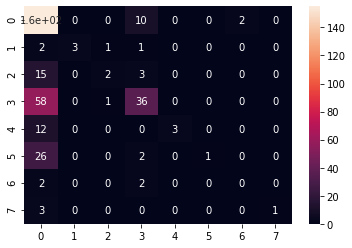

In [41]:
sns.heatmap(cm,annot=True)

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.93      0.70       167
           2       1.00      0.43      0.60         7
           3       0.50      0.10      0.17        20
           4       0.67      0.38      0.48        95
           5       1.00      0.20      0.33        15
           6       1.00      0.03      0.07        29
           7       0.00      0.00      0.00         4
           8       1.00      0.25      0.40         4

    accuracy                           0.59       341
   macro avg       0.72      0.29      0.34       341
weighted avg       0.65      0.59      0.53       341



# Checking Accuracy

In [43]:
print(accuracy_score(y_test,y_pred))

0.5894428152492669


**The Accuracy of the Naive Bayes model is 59%**

# Fitting Linear SVC model

In [44]:
from sklearn.svm import LinearSVC

In [45]:
model=LinearSVC()
model=model.fit(train_tfIdf, y_train)

# Making Predictions

In [46]:
y_pred = model.predict(test_tfIdf)

In [47]:
print(model.score(test_tfIdf, y_test))

0.6832844574780058


# Creating a Data Frame for actual vs predicted data

In [48]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df

,Actual,Predicted
1260,4,4
1629,6,6
540,1,6
1662,6,6
492,1,4
...,...,...
1571,6,1
854,2,3
1108,4,1
1194,4,1


# Checking the performance of model

In [49]:
cm=confusion_matrix(y_test, y_pred)
print(cm)

[[145   1   0  12   0   5   3   1]
 [  2   3   1   1   0   0   0   0]
 [  9   0   3   6   0   2   0   0]
 [ 22   0   2  67   3   1   0   0]
 [  5   0   0   2   7   1   0   0]
 [ 18   0   0   4   0   7   0   0]
 [  1   0   0   2   0   1   0   0]
 [  3   0   0   0   0   0   0   1]]


<AxesSubplot:>

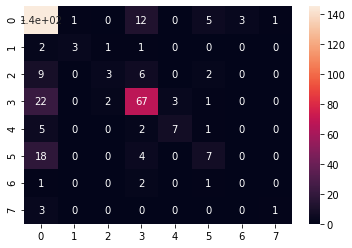

In [50]:
sns.heatmap(cm,annot=True)

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.87      0.78       167
           2       0.75      0.43      0.55         7
           3       0.50      0.15      0.23        20
           4       0.71      0.71      0.71        95
           5       0.70      0.47      0.56        15
           6       0.41      0.24      0.30        29
           7       0.00      0.00      0.00         4
           8       0.50      0.25      0.33         4

    accuracy                           0.68       341
   macro avg       0.54      0.39      0.43       341
weighted avg       0.66      0.68      0.66       341



In [52]:
# Checking Accuracy
print(accuracy_score(y_test,y_pred))

0.6832844574780058


**The Accuracy of the Linear SVC model is 68.3%**

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
model = RandomForestClassifier(n_estimators = 100, max_depth=100, random_state=10)

In [55]:
model=model.fit(train_tfIdf, y_train)

# Making Predictions

In [56]:
y_pred = model.predict(test_tfIdf)

In [57]:
print(model.score(test_tfIdf, y_test))

0.6011730205278593


# Creating a Data Frame for actual vs predicted data

In [58]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df

,Actual,Predicted
1260,4,4
1629,6,6
540,1,6
1662,6,6
492,1,4
...,...,...
1571,6,1
854,2,3
1108,4,1
1194,4,1


# Checking the performance of model

In [59]:
cm=confusion_matrix(y_test, y_pred)
print(cm)

[[141   0   0  18   0   4   3   1]
 [  2   1   1   3   0   0   0   0]
 [ 12   0   2   6   0   0   0   0]
 [ 37   0   1  56   1   0   0   0]
 [ 10   0   0   2   3   0   0   0]
 [ 22   0   0   5   0   2   0   0]
 [  2   0   0   2   0   0   0   0]
 [  3   0   0   1   0   0   0   0]]


<AxesSubplot:>

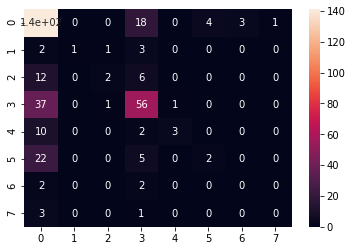

In [60]:
sns.heatmap(cm,annot=True)

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.84      0.71       167
           2       1.00      0.14      0.25         7
           3       0.50      0.10      0.17        20
           4       0.60      0.59      0.60        95
           5       0.75      0.20      0.32        15
           6       0.33      0.07      0.11        29
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         4

    accuracy                           0.60       341
   macro avg       0.48      0.24      0.27       341
weighted avg       0.58      0.60      0.55       341



In [62]:
# Checking Accuracy
print(accuracy_score(y_test,y_pred))

0.6011730205278593


**The Accuracy of the Random Forest Classifier model is 60.1%**

# Out of all models LinearSVC gave high accuracy of 68.3%